In [39]:
import tensorflow as tf 
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input, Dropout, MaxPool2D
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import numpy as np

In [40]:
mnist = tf.keras.datasets.mnist

In [41]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [42]:
type(x_train)

numpy.ndarray

In [43]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

6


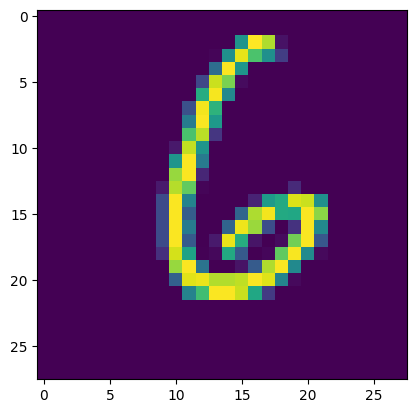

In [44]:
plt.imshow(x_train[32])
print(y_train[32])

In [45]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 64
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).cache().shuffle(len(x_train)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).cache().shuffle(len(x_test)).batch(batch_size)

train_ds = train_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

In [46]:
len(train_ds), len(test_ds)

(938, 157)

In [48]:
inputs = Input((28,28,1))
x = Conv2D(32, 3, activation='relu')(inputs)
x = Conv2D(64, 3, activation='relu')(x)
x = MaxPool2D()(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(10)(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
              , metrics=['accuracy'])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                             

In [ ]:

history = model.fit(train_ds, epochs=5, validation_data=test_ds)

In [ ]:
model.evaluate(test_ds)

In [ ]:
model.save('mnist.h5')